In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
import pandas as pd
import seaborn as sns

In [2]:
# load images
white_bg_img = cv2.imread("./ressources/map_white.png")
ref_points_img = cv2.imread("./ressources/map_references.png")
ref_points_img = cv2.cvtColor(ref_points_img, cv2.COLOR_BGR2RGB)

White Background shape: (4096, 4096, 3)
Ref points resized img shape: (4096, 4096, 3)


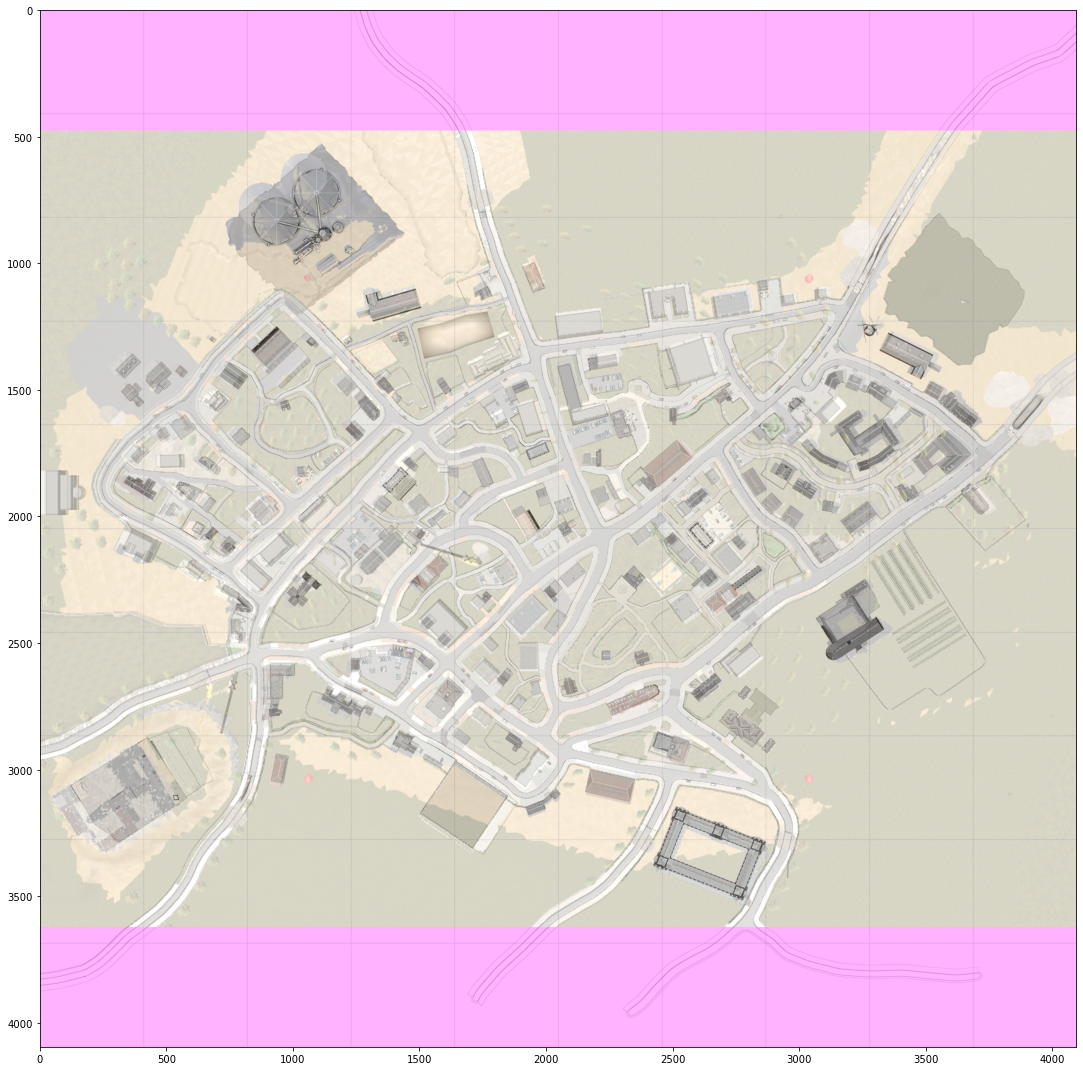

In [3]:
# check sizes of images
print("White Background shape: " + str(np.shape(white_bg_img)))
print("Ref points resized img shape: " + str(np.shape(ref_points_img)))

# check overlay image
overlaied_img = cv2.addWeighted(white_bg_img,0.7,ref_points_img,0.3,0)
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(overlaied_img)
plt.tight_layout()


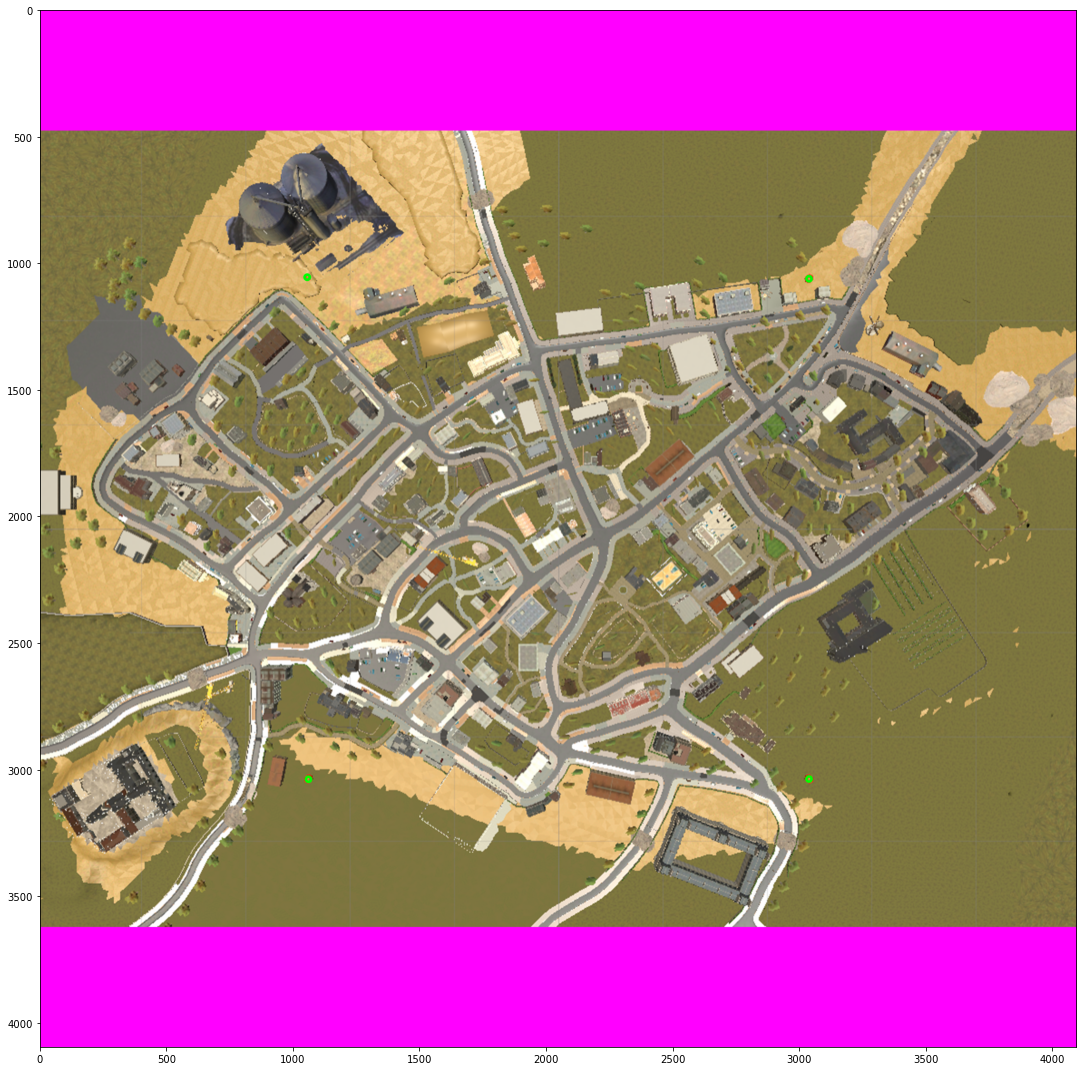

In [4]:
# find ref point coordinates 
ref_points_added = ref_points_img.copy()
cv2.circle(ref_points_added, (1055,1055), 10, (0,300,0), 10) # top left
cv2.circle(ref_points_added, (3037,1061), 10, (0,300,0), 10) # top right
cv2.circle(ref_points_added, (1060,3038), 10, (0,300,0), 10) # bottom left
cv2.circle(ref_points_added, (3037,3037), 10, (0,300,0), 10) # bottom right

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(ref_points_added)
plt.tight_layout()

In [5]:
# Compute transform matrix 
input_pts = np.float32([[240,-240], [-240,-240], [-240,240],[240,240]]) # bottom right, bottom left, top left, top right
target_pts = np.float32([[3037,3037], [1060,3038], [1055,1055], [3037,1061]]) # bottom right, bottom left, top left, top right
transform_matrix = cv2.getPerspectiveTransform(input_pts,target_pts)

In [6]:
def apply_perspective_transform_matrix(matrix, pixel_coords = None, dataframe = None, df_x_name = "", df_y_name = ""):
    '''
    matrix: perspective transform matrix generated with cv2.getPerspectiveTransform()
    pixel_coords: Pixel coordinates in source space to project into target space. Can be list of pixels.
    dataframe: Dataframe holding the source space pixel data. 
    df_x_name: Column name used for x pixel coordinates.
    df_y_name: Column name used for y pixel coordinates.
    Compare https://docs.opencv.org/4.5.2/da/d54/group__imgproc__transform.html#ga20f62aa3235d869c9956436c870893ae 
    '''
    
    # Dataframe not provided 
    if dataframe is None:
    
        # One pixel passed 
        if len(np.shape(pixel_coords)) == 1:

            # Apply matrix 
            result = matrix.dot(np.float32([pixel_coords[0],pixel_coords[1],1]))

            # Remove scalar factor 
            result[0] = result[0] / result[2]
            result[1] = result[1] / result[2]

            return (result[0],result[1])

        # List of pixels
        else:

            # Define method from above again to be able to apply faster to list slices
            def apply_transform(arg):

                result = matrix.dot(np.float32([arg[0],arg[1],1]))
                result[0] = result[0] / result[2]
                result[1] = result[1] / result[2]
                return np.array([result[0],result[1]])

            # Apply to each row in the passed pixel list 
            return np.apply_along_axis(apply_transform,1,pixel_coords)
    
    # Dataframe provided 
    else:
        
        # Init transformed columns
        dataframe["transformed_map_x"] = np.NAN
        dataframe["transformed_map_y"] = np.NAN
     
        # Define method from above again to be able to apply faster to dataframe rows
        def apply_transform(arg):
            
            # Calculate transform
            result = matrix.dot(np.float32([arg[df_x_name],arg[df_y_name],1]))
            result[0] = result[0] / result[2]
            result[1] = result[1] / result[2]
            
            # Add result to dataframe slice
            arg["transformed_map_x"] = result[0]
            arg["transformed_map_y"] = result[1]
            
            return arg
        
            
        # Apply transform 
        dataframe = dataframe.apply(lambda row: apply_transform(row), axis=1)
                                    
        return dataframe




# Test
#print(apply_perspective_transform_matrix(transform_matrix,(240,240)))
#print(apply_perspective_transform_matrix(transform_matrix,input_pts))




In [7]:
# Read example file 
example_df = pd.read_csv("./Results/1023_CompleteExploration_Hitpoints.csv")
example_df[:10]

,Unnamed: 0,timeStampDataPointStart,timeStampDataPointEnd,hitObjectColliderName,ordinalOfHit,hitPointOnObject.x,hitPointOnObject.y,hitPointOnObject.z,hitObjectColliderBoundsCenter.x,hitObjectColliderBoundsCenter.y,hitObjectColliderBoundsCenter.z
0,0,1.619691e+09,1.619691e+09,pavement_O.002,1,-64.191063,1.429070,71.214470,-165.163147,1.451688,-15.555870
1,1,1.619691e+09,1.619691e+09,terrain_S.001,2,-65.567734,1.163447,81.047607,-60.390293,1.153675,100.804741
2,0,1.619691e+09,1.619691e+09,pavement_O.002,1,-64.191063,1.429070,71.214470,-165.163147,1.451688,-15.555870
3,1,1.619691e+09,1.619691e+09,terrain_S.001,2,-65.567734,1.163447,81.047607,-60.390293,1.153675,100.804741
4,0,1.619691e+09,1.619691e+09,pavement_O.002,1,-64.027878,1.426832,70.591492,-165.163147,1.451688,-15.555870
5,1,1.619691e+09,1.619691e+09,road_base_network.004,2,-65.057053,1.221172,78.057304,39.257874,-4.408301,51.768860
6,0,1.619691e+09,1.619691e+09,terrain_S.001,1,-65.711441,1.185995,83.164772,-60.390293,1.153675,100.804741
7,0,1.619691e+09,1.619691e+09,terrain_S.001,1,-66.227020,1.206157,87.327980,-60.390293,1.153675,100.804741
8,0,1.619691e+09,1.619691e+09,pavement_O.002,1,-63.692066,1.419669,68.122917,-165.163147,1.451688,-15.555870
9,1,1.619691e+09,1.619691e+09,road_base_network.004,2,-64.704819,1.200827,75.465088,39.257874,-4.408301,51.768860


In [8]:
# Apply pixel transformation for collider centers 
example_df = apply_perspective_transform_matrix(transform_matrix,dataframe=example_df,df_x_name="hitObjectColliderBoundsCenter.x",df_y_name="hitObjectColliderBoundsCenter.z")
example_df[:10]

,Unnamed: 0,timeStampDataPointStart,timeStampDataPointEnd,hitObjectColliderName,ordinalOfHit,hitPointOnObject.x,hitPointOnObject.y,hitPointOnObject.z,hitObjectColliderBoundsCenter.x,hitObjectColliderBoundsCenter.y,hitObjectColliderBoundsCenter.z,transformed_map_x,transformed_map_y
0,0,1.619691e+09,1.619691e+09,pavement_O.002,1,-64.191063,1.429070,71.214470,-165.163147,1.451688,-15.555870,1367.184847,2112.366126
1,1,1.619691e+09,1.619691e+09,terrain_S.001,2,-65.567734,1.163447,81.047607,-60.390293,1.153675,100.804741,1799.187626,1632.568370
2,0,1.619691e+09,1.619691e+09,pavement_O.002,1,-64.191063,1.429070,71.214470,-165.163147,1.451688,-15.555870,1367.184847,2112.366126
3,1,1.619691e+09,1.619691e+09,terrain_S.001,2,-65.567734,1.163447,81.047607,-60.390293,1.153675,100.804741,1799.187626,1632.568370
4,0,1.619691e+09,1.619691e+09,pavement_O.002,1,-64.027878,1.426832,70.591492,-165.163147,1.451688,-15.555870,1367.184847,2112.366126
5,1,1.619691e+09,1.619691e+09,road_base_network.004,2,-65.057053,1.221172,78.057304,39.257874,-4.408301,51.768860,2210.625643,1835.715762
6,0,1.619691e+09,1.619691e+09,terrain_S.001,1,-65.711441,1.185995,83.164772,-60.390293,1.153675,100.804741,1799.187626,1632.568370
7,0,1.619691e+09,1.619691e+09,terrain_S.001,1,-66.227020,1.206157,87.327980,-60.390293,1.153675,100.804741,1799.187626,1632.568370
8,0,1.619691e+09,1.619691e+09,pavement_O.002,1,-63.692066,1.419669,68.122917,-165.163147,1.451688,-15.555870,1367.184847,2112.366126
9,1,1.619691e+09,1.619691e+09,road_base_network.004,2,-64.704819,1.200827,75.465088,39.257874,-4.408301,51.768860,2210.625643,1835.715762


/Users/stefan/opt/anaconda3/envs/graphs/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/stefan/opt/anaconda3/envs/graphs/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/stefan/opt/anaconda3/envs/graphs/lib/python3.6/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


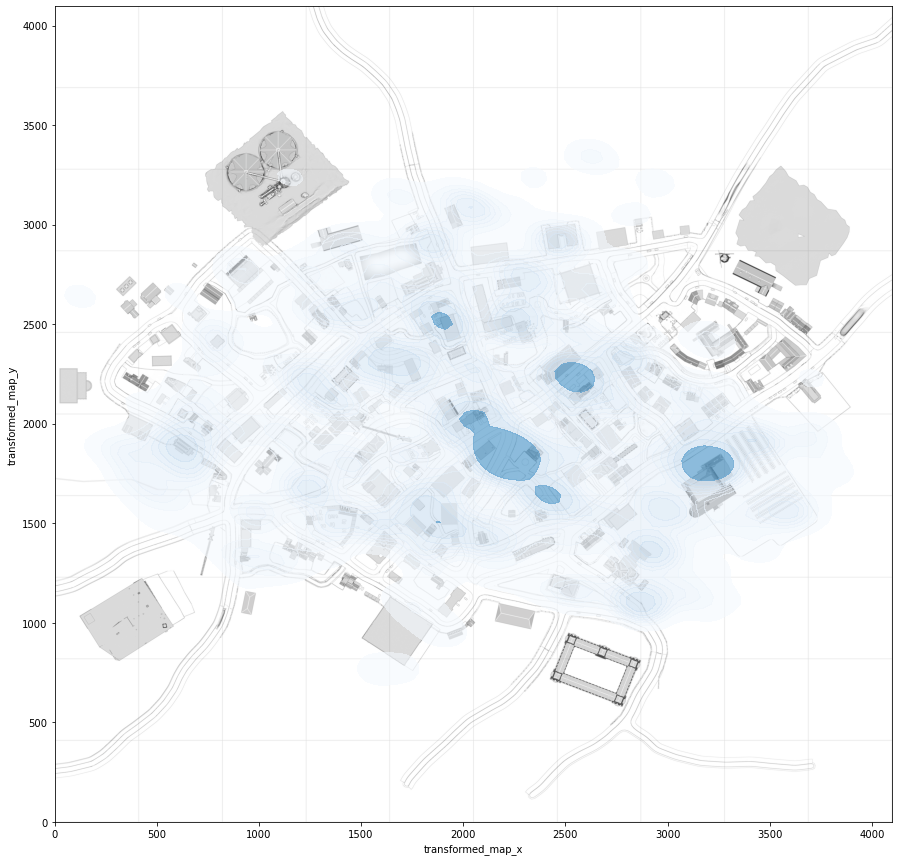

In [9]:
# Calculate KDE Plot for houses on map 

fig, ax = plt.subplots(figsize=(15, 15))

kdeplot = sns.kdeplot(example_df["transformed_map_x"], example_df["transformed_map_y"], bw= 0.1, cmap="Blues", shade=True, shade_lowest=False, alpha = 0.6, zorder=2, ax=ax)
# the function has additional parameters you can play around with to fine-tune your heatmap, e.g.:
#ax = sns.kdeplot(x, y, kernel="gau", bw = 25, cmap="Reds", n_levels = 50, shade=True, shade_lowest=False, gridsize=100)

# plot your KDE
#ax.set_frame_on(False)
plt.xlim(0, 4096)
plt.ylim(0, 4096)
#plt.axis('off')
#plt.show()

# update
kdeplot.imshow(white_bg_img,
         aspect=ax.get_aspect(),
         extent= ax.get_xlim() + ax.get_ylim(),
         zorder=1)

plt.show() # add


# save your KDE to disk
fig = kdeplot.get_figure()
fig.savefig('kde.png', transparent=True, bbox_inches='tight', pad_inches=0)



<AxesSubplot:xlabel='transformed_map_y', ylabel='Count'>

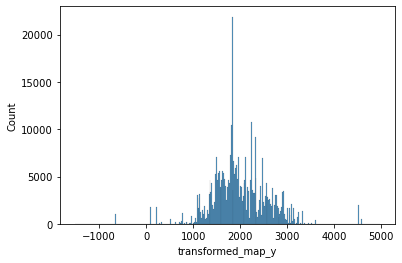

In [10]:
#sns.histplot(example_df["transformed_map_x"])
sns.histplot(example_df["transformed_map_y"])

In [11]:
'''
h = sns.heatmap(np.reshape(example_df["transformed_map_x"],(len(example_df["transformed_map_x"]),)), example_df["transformed_map_y"], alpha=0.1, zorder=2) # update
# update
h.imshow(white_bg_img,
         aspect=h.get_aspect(),
         extent= h.get_xlim() + h.get_ylim(),
         zorder=1)

plt.show() # add


hist,_,_ = np.histogram2d(example_df[:1000]["transformed_map_x"], example_df[:1000]["transformed_map_y"], bins = (np.shape(white_bg_img)[1],np.shape(white_bg_img)[0])) #, bins=(600,800))

# show heatmap by plt
# you can use plt to save the figure
fig = plt.figure(figsize=(12,8))
plt.imshow(hist,cmap='hot')
plt.axis('off')
plt.show()
'''

'\nh = sns.heatmap(np.reshape(example_df["transformed_map_x"],(len(example_df["transformed_map_x"]),)), example_df["transformed_map_y"], alpha=0.1, zorder=2) # update\n# update\nh.imshow(white_bg_img,\n         aspect=h.get_aspect(),\n         extent= h.get_xlim() + h.get_ylim(),\n         zorder=1)\n\nplt.show() # add\n\n\nhist,_,_ = np.histogram2d(example_df[:1000]["transformed_map_x"], example_df[:1000]["transformed_map_y"], bins = (np.shape(white_bg_img)[1],np.shape(white_bg_img)[0])) #, bins=(600,800))\n\n# show heatmap by plt\n# you can use plt to save the figure\nfig = plt.figure(figsize=(12,8))\nplt.imshow(hist,cmap=\'hot\')\nplt.axis(\'off\')\nplt.show()\n'